<a href="https://colab.research.google.com/github/Anjan-AI/TSAI-EVA5/blob/master/Session%206%20-%20Batch%20Normalization%20and%20Regularization/Eva5_session_6_GBN_L1_L2_Regularization_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Session 6 
study the Impact of different regularization technique 
1. Ghost Batch Normalization
2. GBN + L1
3. GBN + L2
4. GBN + L1 L2

# Import Libraries

In [112]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [111]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-12.0, 12.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [113]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [114]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

In [ ]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


TypeError: ignored

## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

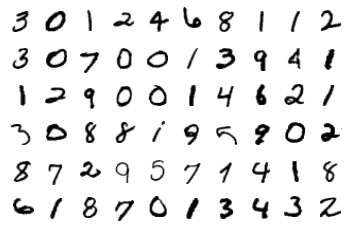

In [ ]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# Ghost Normalization 

In [115]:
# Ghost Noramlization
class GhostBatchNorm(nn.BatchNorm2d):
    def __init__(self, num_features, num_splits, **kw):
        super().__init__(num_features, **kw)
        self.num_splits = num_splits
        self.register_buffer('running_mean', torch.zeros(num_features * self.num_splits))
        self.register_buffer('running_var', torch.ones(num_features * self.num_splits))

    def train(self, mode=True):
        if (self.training is True) and (mode is False):  # lazily collate stats when we are going to use them
            self.running_mean = torch.mean(self.running_mean.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
            self.running_var = torch.mean(self.running_var.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
        return super().train(mode)

    def forward(self, input):
        N, C, H, W = input.shape
        if self.training or not self.track_running_stats:
            return F.batch_norm(
                input.view(-1, C * self.num_splits, H, W), self.running_mean, self.running_var,
                self.weight.repeat(self.num_splits), self.bias.repeat(self.num_splits),
                True, self.momentum, self.eps).view(N, C, H, W)
        else:
            return F.batch_norm(
                input, self.running_mean[:self.num_features], self.running_var[:self.num_features],
                self.weight, self.bias, False, self.momentum, self.eps)


# The model
Let's start with the model we first saw

In [116]:
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            #nn.BatchNorm2d(10),
            GhostBatchNorm(num_features =10, num_splits=2),
            nn.Dropout(dropout_value)
        ) # output_size = 28  RF : 3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=24, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            #nn.BatchNorm2d(24),
            GhostBatchNorm(num_features =24, num_splits=2),
            nn.Dropout(dropout_value)
        ) # output_size = 26   RF : 5

          # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=24, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU() 
        )  # output_size = 26  RF 5
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 13  RF 6

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
           # nn.BatchNorm2d(10),
            GhostBatchNorm(num_features =10, num_splits=2),
            nn.Dropout(dropout_value)
        ) # output_size = 13   RF : 10

        self.convblock41 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            #nn.BatchNorm2d(16),
            GhostBatchNorm(num_features =16, num_splits=2),
            nn.Dropout(dropout_value)
        ) #output_size = 11  RF : 14
       
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
           # nn.BatchNorm2d(16),
            GhostBatchNorm(num_features =16, num_splits=2),
            nn.Dropout(dropout_value)
        ) # output_size = 9  RF :18

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False), 
            nn.ReLU(),
            #nn.BatchNorm2d(16),
            GhostBatchNorm(num_features =16, num_splits=2),
            nn.Dropout(dropout_value)
        ) # output_size = 7 RF 22

        
        self.gap1 = nn.Sequential(
            nn.AvgPool2d(kernel_size =(7,7))
        ) # output_size = 1  RF 34
        #  # Output BLOCK 
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
          
        ) # output_size = 1  RF 34
       

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock41(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.gap1(x)
        x = self.convblock7(x)
        
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [117]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 28, 28]              90
              ReLU-2           [-1, 10, 28, 28]               0
    GhostBatchNorm-3           [-1, 10, 28, 28]              20
           Dropout-4           [-1, 10, 28, 28]               0
            Conv2d-5           [-1, 24, 26, 26]           2,160
              ReLU-6           [-1, 24, 26, 26]               0
    GhostBatchNorm-7           [-1, 24, 26, 26]              48
           Dropout-8           [-1, 24, 26, 26]               0
            Conv2d-9           [-1, 10, 26, 26]             240
             ReLU-10           [-1, 10, 26, 26]               0
        MaxPool2d-11           [-1, 10, 13, 13]               0
           Conv2d-12           [-1, 10, 13, 13]             900
             ReLU-13           [-1, 10, 13, 13]               0
   GhostBatchNorm-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [118]:
from tqdm import tqdm

def train(model, device, train_loader, optimizer, epoch,l1_factor, train_losses, train_acc ):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)

    #implement L1 Loss if l1_factor >0
    if l1_factor > 0:  # Apply L1 regularization
            l1_criteria = nn.L1Loss(size_average=False)
            regularizer_loss = 0
            for parameter in model.parameters():
                regularizer_loss += l1_criteria(parameter, torch.zeros_like(parameter))
            loss += l1_factor * regularizer_loss

    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader,test_losses,test_acc):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

## Function to get the Misclassfied Images & Plot it

In [119]:
def getmissclassifiedImage(model, device, test_loader):
  misclassified = []
  misclassified_pred = []
  misclassified_target = []
  misclassfiled_list = []
  model.eval()

  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
     
      output = model(data)
      pred = output.argmax(dim =1, keepdim =True)
      
      list_misclassified = (pred.eq(target.view_as(pred)) == False)
      batch_misclassified = data[list_misclassified]
      batch_mis_pred = pred[list_misclassified]
      batch_mis_target = target.view_as(pred)[list_misclassified]

      misclassified.append(batch_misclassified)
      misclassified_pred.append(batch_mis_pred)
      misclassified_target.append(batch_mis_target)
                                  
  # group all the batched together
  
  misclassified = torch.cat(misclassified)
  misclassified_pred = torch.cat(misclassified_pred)
  misclassified_target = torch.cat(misclassified_target)  
                                
 
  misclassfiled_list.append(misclassified)
  misclassfiled_list.append(misclassified_pred)
  misclassfiled_list.append(misclassified_pred)

  return list(map(lambda x, y, z: (x, y, z), misclassified, misclassified_pred, misclassified_target))



In [120]:
import random
def Plot_misclassifed(model, device, test_loader):
 misclassified = getmissclassifiedImage(model, device, test_loader)
 num_images = 25
 fig = plt.figure(figsize=(12, 12))
 for idx, (image, pred, target) in enumerate(random.choices(misclassified, k=num_images)):
     image, pred, target = image.cpu().numpy(), pred.cpu(), target.cpu()
     ax = fig.add_subplot(5, 5, idx+1)
     ax.axis('off')
     ax.set_title('target {}\npred {}'.format(target.item(), pred.item()), fontsize=12)
     ax.imshow(image.squeeze())
 plt.show()

# Let's Train and test our model

In [121]:

def runmodel(l1_factor,l2_factor,train_losses,train_acc,test_losses,test_acc):
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,weight_decay=l2_factor)
  scheduler = StepLR(optimizer, step_size=6, gamma=0.1)    
  for epoch in range(EPOCHS):
      print("EPOCH:", epoch)
      train(model, device, train_loader, optimizer, epoch,l1_factor,train_losses,train_acc)
      scheduler.step()
      test(model, device, test_loader,test_losses,test_acc)
  Plot_misclassifed(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

PROCESSING GBN ONLY
EPOCH: 0


Loss=0.16707269847393036 Batch_id=468 Accuracy=81.14: 100%|██████████| 469/469 [00:13<00:00, 35.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1148, Accuracy: 9678/10000 (96.78%)

EPOCH: 1


Loss=0.16753621399402618 Batch_id=468 Accuracy=96.09: 100%|██████████| 469/469 [00:13<00:00, 35.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0743, Accuracy: 9798/10000 (97.98%)

EPOCH: 2


Loss=0.03900853544473648 Batch_id=468 Accuracy=97.09: 100%|██████████| 469/469 [00:13<00:00, 34.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0473, Accuracy: 9851/10000 (98.51%)

EPOCH: 3


Loss=0.04435621574521065 Batch_id=468 Accuracy=97.59: 100%|██████████| 469/469 [00:13<00:00, 34.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0369, Accuracy: 9896/10000 (98.96%)

EPOCH: 4


Loss=0.025953030213713646 Batch_id=468 Accuracy=97.81: 100%|██████████| 469/469 [00:15<00:00, 30.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0432, Accuracy: 9856/10000 (98.56%)

EPOCH: 5


Loss=0.08100974559783936 Batch_id=468 Accuracy=98.03: 100%|██████████| 469/469 [00:15<00:00, 29.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0373, Accuracy: 9885/10000 (98.85%)

EPOCH: 6


Loss=0.060040757060050964 Batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:15<00:00, 30.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0267, Accuracy: 9916/10000 (99.16%)

EPOCH: 7


Loss=0.03870101645588875 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:20<00:00, 22.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0263, Accuracy: 9919/10000 (99.19%)

EPOCH: 8


Loss=0.016244223341345787 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:16<00:00, 28.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0252, Accuracy: 9921/10000 (99.21%)

EPOCH: 9


Loss=0.08943609148263931 Batch_id=468 Accuracy=98.43: 100%|██████████| 469/469 [00:15<00:00, 29.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0250, Accuracy: 9925/10000 (99.25%)

EPOCH: 10


Loss=0.0259482990950346 Batch_id=468 Accuracy=98.51: 100%|██████████| 469/469 [00:15<00:00, 29.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0236, Accuracy: 9926/10000 (99.26%)

EPOCH: 11


Loss=0.1262735277414322 Batch_id=468 Accuracy=98.51: 100%|██████████| 469/469 [00:15<00:00, 30.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0250, Accuracy: 9920/10000 (99.20%)

EPOCH: 12


Loss=0.01924949325621128 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:16<00:00, 28.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0244, Accuracy: 9924/10000 (99.24%)

EPOCH: 13


Loss=0.03364109620451927 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:15<00:00, 30.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0234, Accuracy: 9921/10000 (99.21%)

EPOCH: 14


Loss=0.03972819074988365 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:15<00:00, 30.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0242, Accuracy: 9922/10000 (99.22%)

EPOCH: 15


Loss=0.02389022521674633 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:16<00:00, 29.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0236, Accuracy: 9925/10000 (99.25%)

EPOCH: 16


Loss=0.026502342894673347 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:16<00:00, 29.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0241, Accuracy: 9922/10000 (99.22%)

EPOCH: 17


Loss=0.04835033416748047 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:16<00:00, 27.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Accuracy: 9925/10000 (99.25%)

EPOCH: 18


Loss=0.05226631835103035 Batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [00:16<00:00, 28.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0242, Accuracy: 9928/10000 (99.28%)

EPOCH: 19


Loss=0.06730925291776657 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:13<00:00, 33.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Accuracy: 9925/10000 (99.25%)

EPOCH: 20


Loss=0.015534886159002781 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:13<00:00, 35.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0237, Accuracy: 9926/10000 (99.26%)

EPOCH: 21


Loss=0.061626236885786057 Batch_id=468 Accuracy=98.46: 100%|██████████| 469/469 [00:13<00:00, 35.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0239, Accuracy: 9923/10000 (99.23%)

EPOCH: 22


Loss=0.042028989642858505 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:13<00:00, 35.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0248, Accuracy: 9923/10000 (99.23%)

EPOCH: 23


Loss=0.030844660475850105 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:13<00:00, 34.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0243, Accuracy: 9924/10000 (99.24%)

EPOCH: 24


Loss=0.04211770370602608 Batch_id=468 Accuracy=98.57: 100%|██████████| 469/469 [00:13<00:00, 35.03it/s]



Test set: Average loss: 0.0235, Accuracy: 9927/10000 (99.27%)



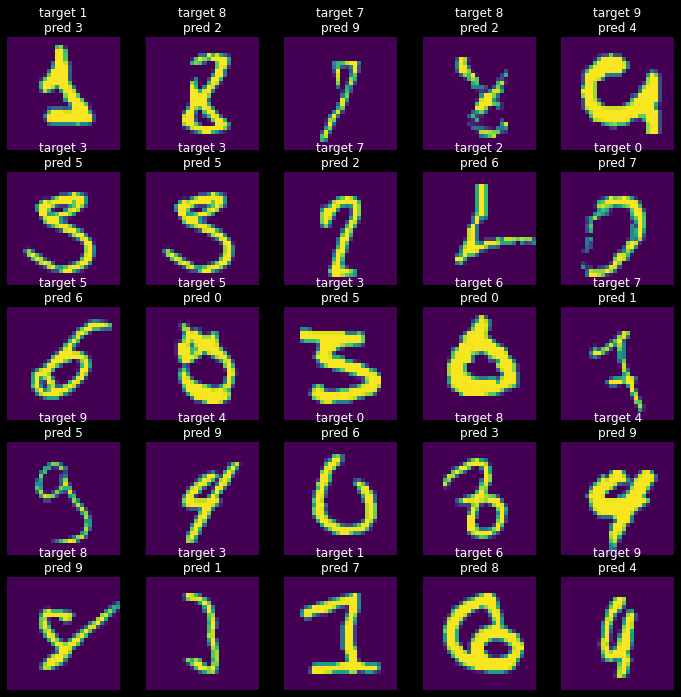

In [122]:
# GBN only 
from torch.optim.lr_scheduler import StepLR
model =  Net().to(device)

EPOCHS = 25

print("PROCESSING GBN ONLY")
l1_factor =0
l2_factor =0
train_losses_GBN = []
test_losses_GBN = []
train_acc_GBN = []
test_acc_GBN = []
runmodel(l1_factor,l2_factor,train_losses_GBN,train_acc_GBN,test_losses_GBN,test_acc_GBN)


PROCESSING GBN + L1 ONLY


  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Loss=0.19285403192043304 Batch_id=468 Accuracy=81.31: 100%|██████████| 469/469 [00:15<00:00, 30.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0826, Accuracy: 9787/10000 (97.87%)

EPOCH: 1


Loss=0.1374584138393402 Batch_id=468 Accuracy=96.59: 100%|██████████| 469/469 [00:17<00:00, 27.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0574, Accuracy: 9836/10000 (98.36%)

EPOCH: 2


Loss=0.20613300800323486 Batch_id=468 Accuracy=97.38: 100%|██████████| 469/469 [00:16<00:00, 27.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0470, Accuracy: 9851/10000 (98.51%)

EPOCH: 3


Loss=0.12999218702316284 Batch_id=468 Accuracy=97.68: 100%|██████████| 469/469 [00:16<00:00, 28.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0521, Accuracy: 9833/10000 (98.33%)

EPOCH: 4


Loss=0.09367606788873672 Batch_id=468 Accuracy=97.98: 100%|██████████| 469/469 [00:17<00:00, 27.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0333, Accuracy: 9905/10000 (99.05%)

EPOCH: 5


Loss=0.09455767273902893 Batch_id=468 Accuracy=98.06: 100%|██████████| 469/469 [00:16<00:00, 27.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0392, Accuracy: 9890/10000 (98.90%)

EPOCH: 6


Loss=0.11666025221347809 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:16<00:00, 28.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Accuracy: 9934/10000 (99.34%)

EPOCH: 7


Loss=0.07804269343614578 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:17<00:00, 27.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9933/10000 (99.33%)

EPOCH: 8


Loss=0.13483253121376038 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:17<00:00, 27.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9935/10000 (99.35%)

EPOCH: 9


Loss=0.11024607717990875 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:17<00:00, 26.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9938/10000 (99.38%)

EPOCH: 10


Loss=0.08864635974168777 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:17<00:00, 27.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9930/10000 (99.30%)

EPOCH: 11


Loss=0.11053772270679474 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:17<00:00, 27.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9930/10000 (99.30%)

EPOCH: 12


Loss=0.07278294116258621 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:17<00:00, 27.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9933/10000 (99.33%)

EPOCH: 13


Loss=0.08631952106952667 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [00:17<00:00, 27.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9936/10000 (99.36%)

EPOCH: 14


Loss=0.06712964177131653 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:16<00:00, 27.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9934/10000 (99.34%)

EPOCH: 15


Loss=0.10854341089725494 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:16<00:00, 27.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9932/10000 (99.32%)

EPOCH: 16


Loss=0.10000032931566238 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:16<00:00, 27.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9935/10000 (99.35%)

EPOCH: 17


Loss=0.1088198870420456 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:16<00:00, 27.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9934/10000 (99.34%)

EPOCH: 18


Loss=0.07524561882019043 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:17<00:00, 27.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9935/10000 (99.35%)

EPOCH: 19


Loss=0.1025184914469719 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:16<00:00, 28.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9935/10000 (99.35%)

EPOCH: 20


Loss=0.09481661021709442 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:15<00:00, 30.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9934/10000 (99.34%)

EPOCH: 21


Loss=0.11777529120445251 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:14<00:00, 31.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9936/10000 (99.36%)

EPOCH: 22


Loss=0.09534305334091187 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:15<00:00, 31.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9934/10000 (99.34%)

EPOCH: 23


Loss=0.17903967201709747 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:14<00:00, 31.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9938/10000 (99.38%)

EPOCH: 24


Loss=0.06401883810758591 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:15<00:00, 30.77it/s]



Test set: Average loss: 0.0212, Accuracy: 9933/10000 (99.33%)



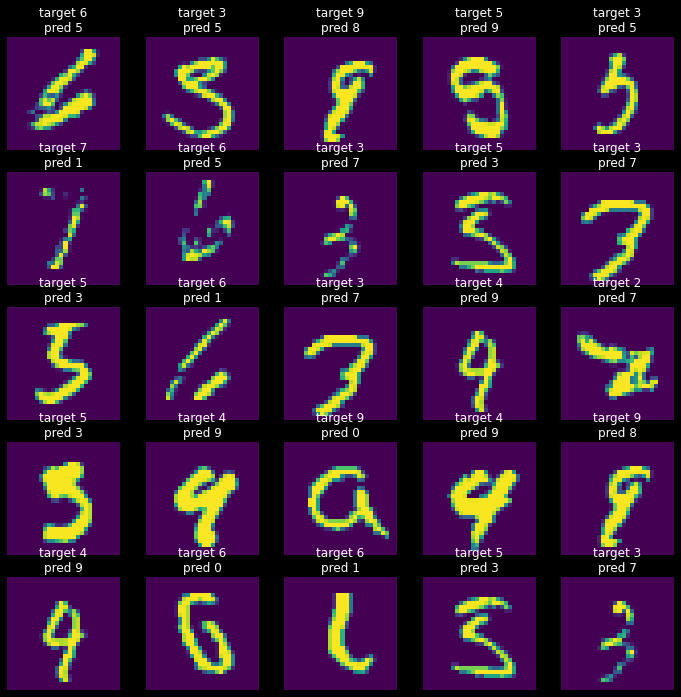

In [123]:
# GBN + L1 
from torch.optim.lr_scheduler import StepLR
model =  Net().to(device)

EPOCHS = 25

print("PROCESSING GBN + L1 ONLY")
l1_factor =0.0001
l2_factor =0
train_losses_GBN_L1 = []
test_losses_GBN_L1 = []
train_acc_GBN_L1 = []
test_acc_GBN_L1 = [] 
runmodel(l1_factor,l2_factor,train_losses_GBN_L1,train_acc_GBN_L1,test_losses_GBN_L1,test_acc_GBN_L1)  
 

  0%|          | 0/469 [00:00<?, ?it/s]

PROCESSING GBN + L2 ONLY
EPOCH: 0


Loss=0.14883309602737427 Batch_id=468 Accuracy=83.64: 100%|██████████| 469/469 [00:13<00:00, 34.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0787, Accuracy: 9798/10000 (97.98%)

EPOCH: 1


Loss=0.15939490497112274 Batch_id=468 Accuracy=96.72: 100%|██████████| 469/469 [00:13<00:00, 35.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0575, Accuracy: 9847/10000 (98.47%)

EPOCH: 2


Loss=0.11400318145751953 Batch_id=468 Accuracy=97.47: 100%|██████████| 469/469 [00:13<00:00, 34.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0509, Accuracy: 9850/10000 (98.50%)

EPOCH: 3


Loss=0.038997583091259 Batch_id=468 Accuracy=97.87: 100%|██████████| 469/469 [00:13<00:00, 34.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0326, Accuracy: 9904/10000 (99.04%)

EPOCH: 4


Loss=0.13846124708652496 Batch_id=468 Accuracy=98.04: 100%|██████████| 469/469 [00:13<00:00, 35.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0354, Accuracy: 9901/10000 (99.01%)

EPOCH: 5


Loss=0.04754268005490303 Batch_id=468 Accuracy=98.20: 100%|██████████| 469/469 [00:13<00:00, 34.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0313, Accuracy: 9912/10000 (99.12%)

EPOCH: 6


Loss=0.09920873492956161 Batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [00:13<00:00, 34.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0237, Accuracy: 9927/10000 (99.27%)

EPOCH: 7


Loss=0.034089185297489166 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:13<00:00, 35.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0236, Accuracy: 9929/10000 (99.29%)

EPOCH: 8


Loss=0.025644389912486076 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:13<00:00, 34.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Accuracy: 9921/10000 (99.21%)

EPOCH: 9


Loss=0.07660408318042755 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:13<00:00, 35.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9930/10000 (99.30%)

EPOCH: 10


Loss=0.012495412491261959 Batch_id=468 Accuracy=98.57: 100%|██████████| 469/469 [00:13<00:00, 35.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9926/10000 (99.26%)

EPOCH: 11


Loss=0.031975556164979935 Batch_id=468 Accuracy=98.57: 100%|██████████| 469/469 [00:13<00:00, 34.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9929/10000 (99.29%)

EPOCH: 12


Loss=0.04616029933094978 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:13<00:00, 34.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9929/10000 (99.29%)

EPOCH: 13


Loss=0.048150792717933655 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:13<00:00, 34.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9931/10000 (99.31%)

EPOCH: 14


Loss=0.049484312534332275 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [00:13<00:00, 33.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9935/10000 (99.35%)

EPOCH: 15


Loss=0.0164544228464365 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:13<00:00, 34.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9929/10000 (99.29%)

EPOCH: 16


Loss=0.019478201866149902 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:13<00:00, 35.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9930/10000 (99.30%)

EPOCH: 17


Loss=0.03601761907339096 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:13<00:00, 34.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9929/10000 (99.29%)

EPOCH: 18


Loss=0.04981647804379463 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:13<00:00, 35.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9932/10000 (99.32%)

EPOCH: 19


Loss=0.015000891871750355 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:13<00:00, 34.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9928/10000 (99.28%)

EPOCH: 20


Loss=0.11798611283302307 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [00:13<00:00, 34.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9932/10000 (99.32%)

EPOCH: 21


Loss=0.017870524898171425 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:13<00:00, 34.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9933/10000 (99.33%)

EPOCH: 22


Loss=0.01669744960963726 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:13<00:00, 34.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9932/10000 (99.32%)

EPOCH: 23


Loss=0.037905555218458176 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:13<00:00, 34.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9932/10000 (99.32%)

EPOCH: 24


Loss=0.014559131115674973 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:13<00:00, 34.38it/s]



Test set: Average loss: 0.0223, Accuracy: 9932/10000 (99.32%)



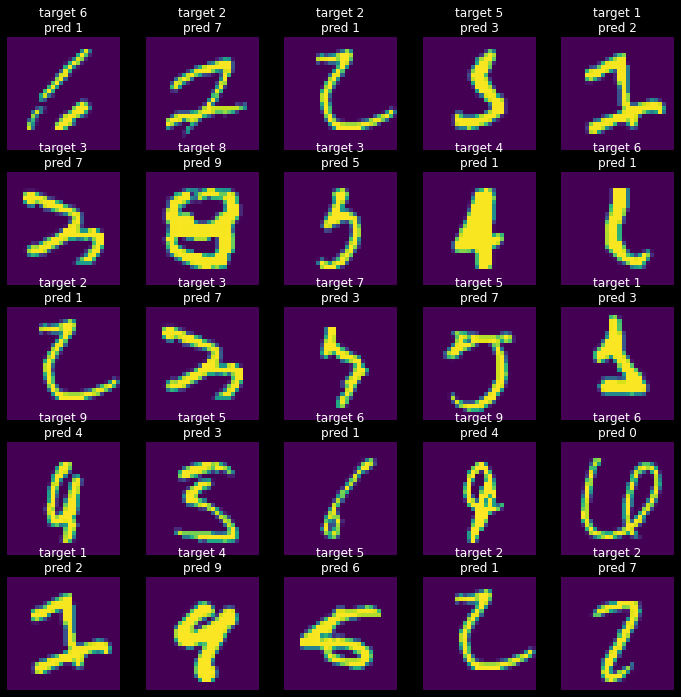

In [124]:
# GBN + L2
from torch.optim.lr_scheduler import StepLR
model =  Net().to(device)

EPOCHS = 25

print("PROCESSING GBN + L2 ONLY")
l1_factor =0
l2_factor =0.0001
train_losses_GBN_L2 = []
test_losses_GBN_L2 = []
train_acc_GBN_L2 = []
test_acc_GBN_L2 = []
runmodel(l1_factor,l2_factor,train_losses_GBN_L2,train_acc_GBN_L2,test_losses_GBN_L2,test_acc_GBN_L2)


  0%|          | 0/469 [00:00<?, ?it/s]

PROCESSING GBN + L1 & L2 
EPOCH: 0


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Loss=0.20482318103313446 Batch_id=468 Accuracy=84.42: 100%|██████████| 469/469 [00:15<00:00, 30.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1003, Accuracy: 9708/10000 (97.08%)

EPOCH: 1


Loss=0.14782896637916565 Batch_id=468 Accuracy=96.90: 100%|██████████| 469/469 [00:16<00:00, 28.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0690, Accuracy: 9795/10000 (97.95%)

EPOCH: 2


Loss=0.1719845086336136 Batch_id=468 Accuracy=97.48: 100%|██████████| 469/469 [00:15<00:00, 30.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0481, Accuracy: 9848/10000 (98.48%)

EPOCH: 3


Loss=0.19423897564411163 Batch_id=468 Accuracy=97.86: 100%|██████████| 469/469 [00:15<00:00, 30.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0415, Accuracy: 9864/10000 (98.64%)

EPOCH: 4


Loss=0.07870287448167801 Batch_id=468 Accuracy=98.12: 100%|██████████| 469/469 [00:15<00:00, 30.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0366, Accuracy: 9888/10000 (98.88%)

EPOCH: 5


Loss=0.09052661061286926 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:15<00:00, 29.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0298, Accuracy: 9917/10000 (99.17%)

EPOCH: 6


Loss=0.1316879689693451 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:15<00:00, 30.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9933/10000 (99.33%)

EPOCH: 7


Loss=0.1257970631122589 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:15<00:00, 31.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9929/10000 (99.29%)

EPOCH: 8


Loss=0.1462341845035553 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:15<00:00, 30.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9939/10000 (99.39%)

EPOCH: 9


Loss=0.11153928935527802 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:15<00:00, 31.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9937/10000 (99.37%)

EPOCH: 10


Loss=0.11301282793283463 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:15<00:00, 30.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9935/10000 (99.35%)

EPOCH: 11


Loss=0.06201805919408798 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:15<00:00, 30.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9935/10000 (99.35%)

EPOCH: 12


Loss=0.10755185782909393 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:15<00:00, 30.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9939/10000 (99.39%)

EPOCH: 13


Loss=0.08590912073850632 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:15<00:00, 30.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9936/10000 (99.36%)

EPOCH: 14


Loss=0.08150292932987213 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:15<00:00, 30.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9938/10000 (99.38%)

EPOCH: 15


Loss=0.07608450204133987 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:15<00:00, 30.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9939/10000 (99.39%)

EPOCH: 16


Loss=0.10790243744850159 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:14<00:00, 31.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9940/10000 (99.40%)

EPOCH: 17


Loss=0.10902222990989685 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:14<00:00, 31.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9938/10000 (99.38%)

EPOCH: 18


Loss=0.08762957155704498 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:15<00:00, 31.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9941/10000 (99.41%)

EPOCH: 19


Loss=0.09687106311321259 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:15<00:00, 31.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9940/10000 (99.40%)

EPOCH: 20


Loss=0.0971001535654068 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:15<00:00, 30.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9938/10000 (99.38%)

EPOCH: 21


Loss=0.10652382671833038 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:15<00:00, 30.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9940/10000 (99.40%)

EPOCH: 22


Loss=0.06884315609931946 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:14<00:00, 31.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9938/10000 (99.38%)

EPOCH: 23


Loss=0.10284353792667389 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:15<00:00, 30.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9940/10000 (99.40%)

EPOCH: 24


Loss=0.12893813848495483 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:15<00:00, 30.57it/s]



Test set: Average loss: 0.0203, Accuracy: 9940/10000 (99.40%)



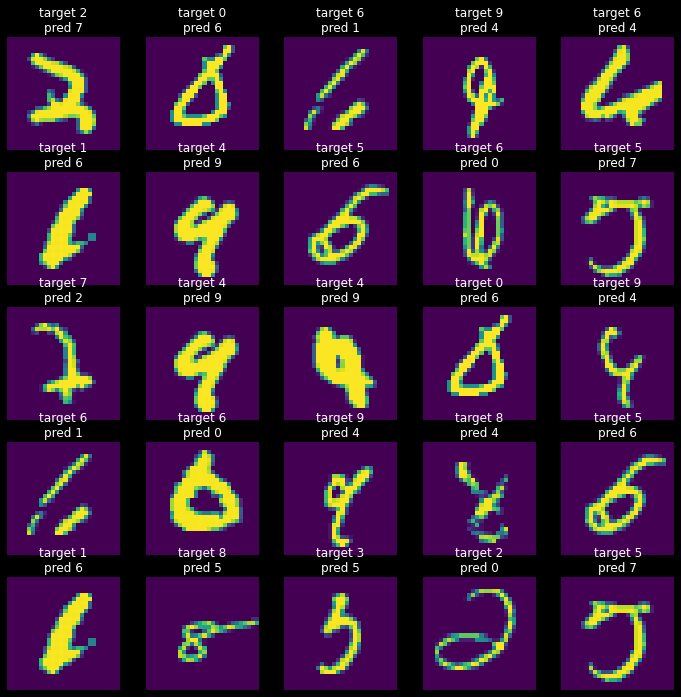

In [125]:
# GBN + L1 L2
from torch.optim.lr_scheduler import StepLR
model =  Net().to(device)

EPOCHS = 25
print("PROCESSING GBN + L1 & L2 ")
l1_factor =0.0001
l2_factor =0.0001
train_losses_GBN_L12 = []
test_losses_GBN_L12 = []
train_acc_GBN_L12 = []
test_acc_GBN_L12 = []
runmodel(l1_factor,l2_factor,train_losses_GBN_L12,train_acc_GBN_L12,test_losses_GBN_L12,test_acc_GBN_L12)

In [128]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_metric(GBN, l1, l2, l1_l2, metric):
    # Initialize a figure
    plt.style.use("dark_background")
    fig = plt.figure(figsize=(11, 9))
    
    # Plot values
    GBN_plt, = plt.plot(GBN)
    l1_plt, = plt.plot(l1)
    l2_plt, = plt.plot(l2)
    l1_l2_plt, = plt.plot(l1_l2)

    # Set plot title
    plt.title(f' {metric}')

    # Label axes
    plt.xlabel('Epoch')
    plt.ylabel(metric)

    # Set legend
    location = 'upper' if ((metric == 'Test loss') or (metric == 'Train loss')) else 'lower'
    plt.legend(
        (GBN_plt, l1_plt, l2_plt, l1_l2_plt),
        ('GBN', 'L1', 'L2', 'L1 + L2'),
        loc=f'{location} right',
        shadow=True,
        prop={'size': 10}
    )

    # Save plot
    fig.savefig(f'{metric.lower()}_change.png')

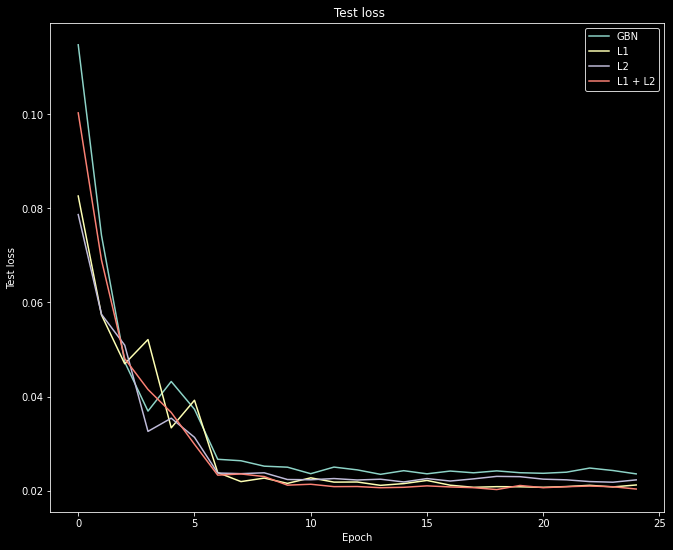

In [129]:
plot_metric(test_losses_GBN, test_losses_GBN_L1, test_losses_GBN_L2, test_losses_GBN_L12, 'Test loss')


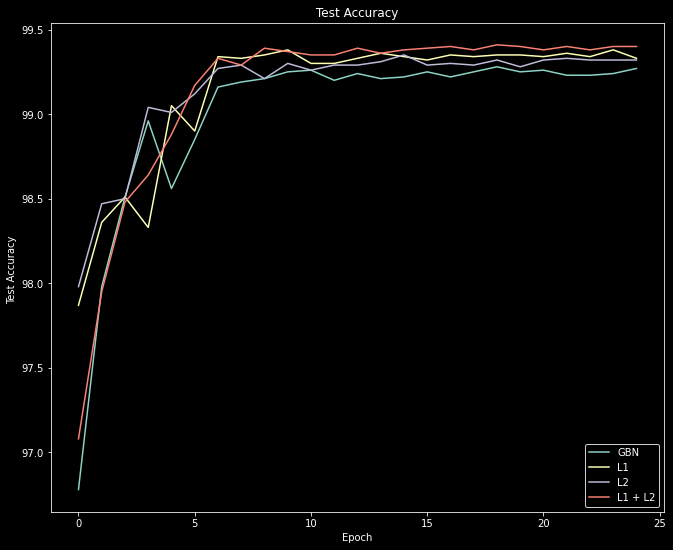

In [130]:
plot_metric(test_acc_GBN, test_acc_GBN_L1, test_acc_GBN_L2, test_acc_GBN_L12, 'Test Accuracy ')


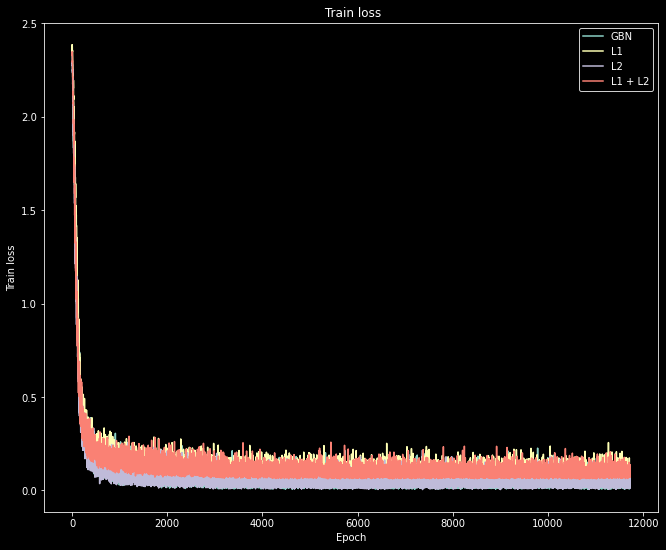

In [131]:
plot_metric(train_losses_GBN, train_losses_GBN_L1, train_losses_GBN_L2, train_losses_GBN_L12, 'Train loss')


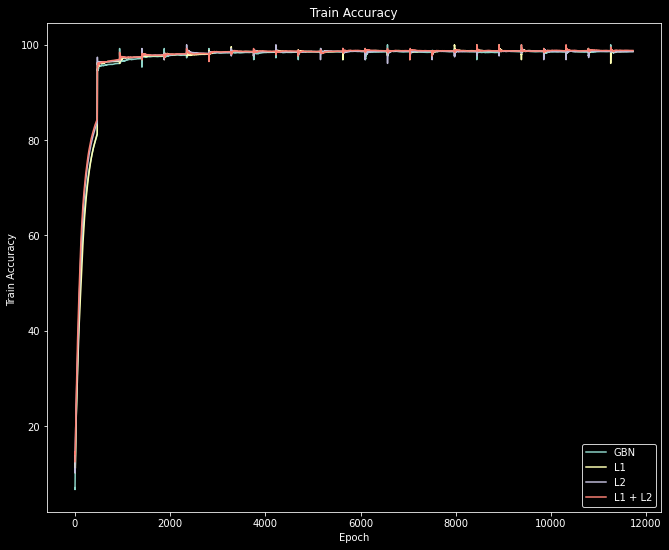

In [132]:
plot_metric(train_acc_GBN, train_acc_GBN_L1, train_acc_GBN_L2, train_acc_GBN_L12, 'Train Accuracy ')